# Basic Rasterization

__framebuffers, dispatching primitives, instances__ 

A distinctive aspect of a rasterizer is the way output is handled. In a compute shader, generated image is accessed in random positions to store the output value. In a rasterizer, it is convenient that multiple targets and depth-stencil buffers are aligned and there is an implicit process consuming colors, depth, and stencil values, operating with them and then updating the respective buffers. The attached images for colors can be set in the fragment shader using out locations, while the depth-stencil operation can be statically defined in the pipeline or dynamically in the command buffer manager.

In this tutorial we will render different quads showing the setup of graphics pipelines and how instances works.

In [1]:
import vulky as vk
import torch

vk.create_device(debug=True)

[INFO] Debug instance created...
[PRINT] Inserted device layer "VK_LAYER_KHRONOS_validation" (C:\VulkanSDK\1.3.275.0\Bin\.\VkLayer_khronos_validation.dll)
[PRINT] Inserted device layer "VK_LAYER_OBS_HOOK" (C:\ProgramData\obs-studio-hook\.\graphics-hook64.dll)
[PRINT] Inserted device layer "VK_LAYER_NV_optimus" (C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll)
[PRINT] vkCreateDevice layer callstack setup to:
[PRINT]    <Application>
[PRINT]      ||
[PRINT]    <Loader>
[PRINT]      ||
[PRINT]    VK_LAYER_NV_optimus
[PRINT]            Type: Implicit
[PRINT]                Disable Env Var:  DISABLE_LAYER_NV_OPTIMUS_1
[PRINT]            Manifest: C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\nv-vk64.json
[PRINT]            Library:  C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll
[PRINT]      ||
[PRINT]    VK_LAYER_OBS_HOOK
[PRINT]            Type: Implici

Next, some constants to parameterize the example:

In [2]:
SCREEN_WIDTH = 512
SCREEN_HEIGHT = 512
NUMBER_OF_SPRITES = 30

Let's create the images for render target and depth buffer. They will have the same dimension. Automatically vulky will use the format for depth-stencil buffer with better definition.

In [3]:
render_target = vk.render_target(
    image_format=vk.Format.VEC4,
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT
)

depth_buffer = vk.depth_stencil(
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT
)

We will define a buffer with the properties for the sprites, one for each instance.

In [4]:
sprite_properties = vk.structured_buffer(
    count=NUMBER_OF_SPRITES,
    element_description=dict(
        offset=vk.vec3,
        size=float,
        color=vk.vec4,
    )
)

Now let's populate randomly. They will represent boxes in the screen, the offset z will be used for depth and the color

In [5]:
with sprite_properties.map(mode='in', clear=True) as b:
    b.offset = torch.rand(NUMBER_OF_SPRITES, 3)*2 - 1.0
    b.offset.z *= 0.5
    b.offset.z += 0.5
    b.size = torch.randn(NUMBER_OF_SPRITES, 1)*0.05
    b.color = vk.vec4(0.5, 0.5, 0.5, 0.5) + torch.randn(NUMBER_OF_SPRITES, 4)*0.1
    # b.color is a vec4, b.color[0] is not the first color but the first component for all colors
    b.color[0] = 1.0  # set the red component for all 30 colors to 1.
    # but cast to torch.Tensor is possible, meaning that is valid
    b.color.as_subclass(torch.Tensor)[:NUMBER_OF_SPRITES//2, 3] = 1.0  
    # That makes all alpha components for the first 15 colors 1.0

Mapped buffers can be accessed by the fields. The set access to the field will copy a tensor or constant to the field for all elements in the buffer. Notice that if the element is a vector or a matrix, the indexing will behave differently. Next, let's define the vertex and fragment shader code.

In [6]:
vertex_shader_code = """
#version 450
#extension GL_EXT_scalar_block_layout: enable

layout(location = 0) out vec4 out_color;

struct SpriteInfo
{
    vec3 offset;
    float size;
    vec4 color;
};

layout(scalar, set=0, binding=0) buffer SpriteInfos {
    SpriteInfo[] data;
} infos;

vec2[] quad = {
    vec2(-1.0, -1.0), 
    vec2(1.0, -1.0),
    vec2(-1.0, 1.0),
    vec2(-1.0, 1.0),
    vec2(1.0, -1.0),
    vec2(1.0, 1.0)
};

void main()
{
    SpriteInfo info = infos.data[gl_InstanceIndex];
    vec4 P = vec4(vec3(quad[gl_VertexIndex], 0)*info.size + info.offset, 1.0);
    gl_Position = P;
    out_color = info.color;
}
"""
fragment_shader_code = """
#version 450
layout(location = 0) in vec4 in_color;
layout(location = 0) out vec4 out_color;
void main()
{
    out_color = in_color;
}
"""

Notice that the vertex shader will operate on ```gl_VertexIndex``` and ```gl_InstanceIndex``` builtins. Now, let's define the pipeline object that will relate shaders, the resources bindings and the targets of the framebuffer.

In [7]:
pipeline = vk.pipeline_graphics()
pipeline.attach(0, render_target=vk.Format.VEC4)
pipeline.attach(1, depth_buffer=vk.Format.DEPTH_STENCIL)
pipeline.layout(set=0, binding=0, sprite_properties=vk.DescriptorType.STORAGE_BUFFER)
with pipeline.shader_stages(vk.ShaderStage.VERTEX):
    pipeline.load_shader_from_source(vertex_shader_code)
with pipeline.shader_stages(vk.ShaderStage.FRAGMENT):
    pipeline.load_shader_from_source(fragment_shader_code)
pipeline.close()

Once the pipeline is closed, the layout is defined, and derived objects can be created, framebuffers and descriptor set collections. The framebuffer object defines the images that are bound to the pipeline before execution. In vulkan, a render pass (involving a framebuffer) can define subpasses to optimize for dependencies between targets. In vulky, it is simplified to a single subpass.  

In [8]:
framebuffer = pipeline.create_framebuffer(
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT,
    render_target=render_target,
    depth_buffer=depth_buffer
)

The pipeline is also used to create the descriptor set, in this example to bind a buffer with all sprite properties.

In [9]:
global_bindings = pipeline.create_descriptor_set_collection(set=0, count=1)
global_bindings[0].update(sprite_properties=sprite_properties)

Next, we will populate a command buffer. As an example, we will record the commands with a manager and freeze it before submitting. This is the way vulky allows to re-submit the same command buffer. Although, in this example we wont submit several time, equivalent to use within a context.

In [10]:
man = vk.graphics_manager()

Now, we can clear the render target with dark blue. Images don't need to transition because it will be done internally when necessary. Anyway, image barriers are supported but only to synchronize between two parts of the command buffer.

In [11]:
man.clear_color(render_target, (0.0, 0.0, 0.4, 1.0))
man.clear_depth_stencil(depth_buffer, 1.0, 0)

Then, lets set the pipeline and the framebuffer. Also, the global descriptor set.

In [12]:
man.set_pipeline(pipeline)
man.set_framebuffer(framebuffer)
man.bind(global_bindings[0])

At this point the graphics pipeline is setup and the implicit render pass to draw primitives. By default, the pipeline is assuming triangles topology. That can change. The next instruction will dispatch 30 instances of 6 vertices (2 triangles each).

In [13]:
man.dispatch_primitives(vertices=6, instances=30)

After populating the command buffer we can use freeze to close the command and prepare for submit.

In [14]:
man.freeze()

Now we ask vulky to submit a command buffer. The difference between ```close``` and ```freeze``` is that the inner command buffer if closed gets released automatically to be reused to record again. On the contrary, ```freeze``` will keep it available to re-submit if needed. 

In [15]:
vk.submit(man)

Next we copy the render target to a staging buffer. The difference is that now we require to transition the layout of the render target to the general case (use ANY).

In [16]:
staging = vk.tensor(render_target.height, render_target.width, 4) 
render_target.save(staging)

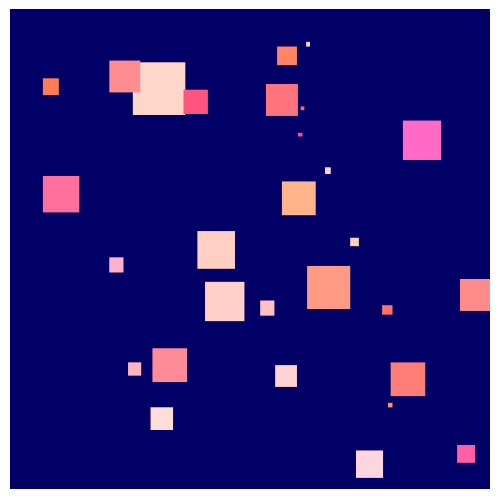

In [17]:
import matplotlib.pyplot as plt
plt.imshow(staging.cpu())
plt.gca().axis('off')
plt.tight_layout(pad=0.0)
plt.show()

Let's prepare a simple animation for this example

In [18]:
video_data = vk.tensor(100, SCREEN_HEIGHT, SCREEN_WIDTH, 3)  # 100 frames
initial_offset = torch.rand(NUMBER_OF_SPRITES, 3)*2 - 1.0
initial_offset[..., 2] *= 0.5
initial_offset[..., 2] += 0.5

In [19]:
for i in range(len(video_data)):
    alpha = i / len(video_data)
    # update buffer
    # we use inout because we won't change everything, just a field
    with sprite_properties.map(mode='inout') as b:  
        b.offset = initial_offset
        b.offset.y += torch.abs(torch.sin(((initial_offset[...,0] * 100)%1.0)*10 + alpha*30))*0.1
        b.offset.x += torch.cos(((initial_offset[...,1]*40)%1.0)*10 + alpha*4)*0.3
    # re-submit commands to gpu
    with vk.graphics_manager() as b:  # transit from general to render target before rendering
        b.use(render_target, vk.ImageUsage.ANY)
        b.image_barrier(render_target, vk.ImageUsage.RENDER_TARGET)
    vk.submit(man)  # by default will wait until finishes
    with vk.graphics_manager() as b:  # transit from render target to general before saving
        b.use(render_target, vk.ImageUsage.RENDER_TARGET)
        b.image_barrier(render_target, vk.ImageUsage.ANY)
    render_target.save(staging)
    video_data[i] = staging[...,:3]  # copy current frame to video (only RGB)    


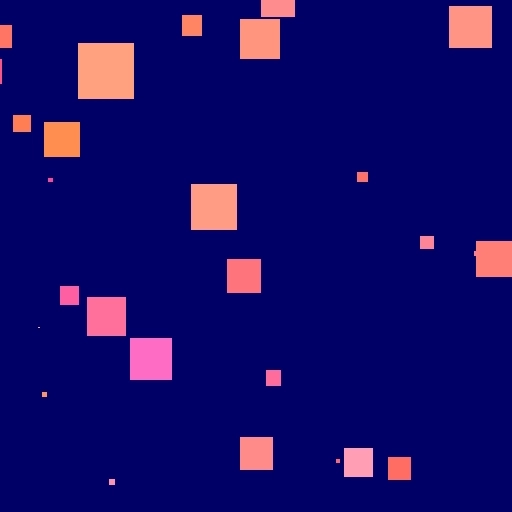

In [20]:
vk.save_video(video_data, 'teaser3.webp', 10, quality=100)
import moviepy.editor
moviepy.editor.ipython_display("teaser3.webp", filetype='image')